In [1]:
import json
from datetime import datetime , timezone
import time
import numpy as np
import codecs
import struct
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pycorrelate
import collections
import itertools
from mpl_toolkits import mplot3d
import cv2
import imutils
import os

pd.set_option('display.max_rows', 1000)
%matplotlib inline

In [2]:
metadata = pickle.load(open('./cleaned_data/metadata.p', 'rb'))
print('Please Choose a Session to Work With:')
for k in metadata: print(k, end=',  ')

Please Choose a Session to Work With:
david_2,  patrick_1,  patrick_2,  beata_1,  david_3b,  irmandy_1,  juliana_1,  irmandy_2,  patrick_3,  

In [73]:
SESSION = 'patrick_3'
#VIDEO_NAME = '/Volumes/ExtDrive_(ResEnv)/data_cap_val_2/david_3/video_part_2.mp4'
VIDEO_NAME = '/Volumes/ExtDrive_(ResEnv)/data_cap_val_2/' + SESSION + '/video_1.mp4'

In [74]:
#load video data (eyeratio and openface features), 60 Hz (16 ms between samples)
df_vid = pd.read_csv('./cleaned_data/' + SESSION + '/video_consolidated.csv', index_col=0)

best_offset = pickle.load(open('./cleaned_data/' + SESSION + '/best_offset.p', "rb" ))

#load glasses blink data, 1kHz (1 ms between samples)
blink_sess = pickle.load(open('./cleaned_data/' + SESSION + '/sessions_blink.p', 'rb'))
blink_sessions = pd.concat(blink_sess)
blink_sessions['timestamp_ms'] = blink_sessions['timestamp_ms'] + best_offset

hand_annotations = pickle.load(open('./cleaned_data/' + SESSION + '/hand_annotations.p', "rb" ))

vid_meta_data = pickle.load(open('./cleaned_data/' + SESSION + '/video_blink_sessions.p', "rb" ))


df_glasses_blinks = pickle.load(open('./cleaned_data/' + SESSION + '/glasses_all_blink_timestamps_uncorrected.p', "rb" ))
df_glasses_blinks['timestamp_ms'] = df_glasses_blinks['timestamp_ms'] + best_offset

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [75]:
results = pickle.load(open('./cleaned_data/' + SESSION + '/final_results.p', "rb" ))
print(SESSION)
print('openface    : Sensitivity/False Disc: %3.2f , %3.2f'%(results['openface']['sensitivity'], results['openface']['false_discovery']))
print('glasses     : Sensitivity/False Disc: %3.2f , %3.2f'%(results['glasses']['sensitivity'], results['glasses']['false_discovery']))
print('filt glasses: Sensitivity/False Disc: %3.2f , %3.2f'%(results['glasses_filtered']['sensitivity'], results['glasses_filtered']['false_discovery']))

patrick_3
openface    : Sensitivity/False Disc: 66.91 , 45.99
glasses     : Sensitivity/False Disc: 94.85 , 37.23
filt glasses: Sensitivity/False Disc: 92.46 , 23.56


Pull out annotation times, and the corresponding blink times, in lists where there is an index for each one

In [76]:
def df_between_timestamps(df, time_col, start_time, end_time):
    return df[(start_time <= df[time_col]) & (df[time_col] <= end_time)].copy()

def string_to_timestamp_ms(datestring):
    return datetime.strptime(datestring, '%m/%d/%y %I:%M:%S%p %Z').timestamp()*1000

flatten = lambda t: [item for sublist in t for item in sublist]

In [77]:
annotated_blink_sections = hand_annotations.keys()

times_to_view = [vid_meta_data['session_times'][i] for i in annotated_blink_sections]
annot_blinks = [hand_annotations[i] for i in annotated_blink_sections]
video_blinks = [vid_meta_data['blink_timestamps_per_session'][i] for i in annotated_blink_sections]
glass_blinks = [df_between_timestamps(df_glasses_blinks, 'timestamp_ms', t[0], t[1])['timestamp_ms'].tolist() for t in times_to_view]  

In [78]:
def stream_with_blink_data_overlay(i, blink_times, chop_start_min=0, chop_end_min=0, slow_down_ratio=1, fps=59.94):

    video_start_timestamp_ms = string_to_timestamp_ms(metadata[SESSION]['vid_start'])
    start_timestamp_ms = times_to_view[i][0]
    end_timestamp_ms = times_to_view[i][1]
    
    start_frame = int(((start_timestamp_ms - video_start_timestamp_ms)/1000)*fps)
    end_frame   = int(((end_timestamp_ms   - video_start_timestamp_ms)/1000)*fps)
  
    #blink times to frame list:
    stream_starttime_sec = video_start_timestamp_ms/1000. + start_frame/fps
    frame_duration_sec = 1/fps #time between frames in sec
    
    if slow_down_ratio == 1:
        ms_delay = 1
    else:
        ms_delay = int(slow_down_ratio*(1/60)*1000) #map 2 to twice as slow as 60Hz delay in ms, 3 as 3x, etc
     
    blink_sig = np.zeros(end_frame-start_frame)
    blink_dur_sec = 0.5
    blink_dur_sample = int(blink_dur_sec*fps)

    #whenever we have a blink, put ones in there for blink_dur frames.  Make sure the sample before that blink is zero
    for btime in blink_times:
        btime_sec_stream = (btime/1000.)-stream_starttime_sec
        bframe = int(btime_sec_stream*fps)

        if bframe >=0 and (bframe + blink_dur_sample) < len(blink_sig):
            blink_sig[bframe-1] = 0  
            blink_sig[bframe:bframe+blink_dur_sample] = 1
        elif bframe < 1 and bframe + blink_dur_sample > 0:
            try:
                blink_sig[0:bframe+blink_dur_sample] = 1
            except:
                blink_sig[0:-1] = 1
        elif bframe + blink_dur_sample > len(blink_sig) and bframe < (end_frame-start_frame):
            blink_sig[bframe-1] = 0  
            blink_sig[bframe:-1] = 1
    
    WINDOW_NAME = 'blink_window'
    cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_AUTOSIZE)
    cv2.startWindowThread()
    
    vs = cv2.VideoCapture(VIDEO_NAME)
    vs.set(cv2.CAP_PROP_POS_FRAMES, start_frame+int(chop_start_min*60*fps))
    time.sleep(1.0)
    
    blink_count, prev_frame = 0,0
    
    for fno in range(int(chop_start_min*60*fps), (end_frame-int(chop_end_min*60*fps))-(start_frame+int(chop_start_min*60*fps))):
        _, frame = vs.read()  
        
        if not fno:
            os.system('''/usr/bin/osascript -e 'tell app "Finder" to set frontmost of process "Python" to true' ''') 
    
        if blink_sig[fno] and not prev_frame:
            blink_count += 1

        cv2.putText(frame, "COUNT: %d"%(blink_count), (20, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        cv2.putText(frame, "TIME: %2.2f"%(chop_start_min + ((fno-int(chop_start_min*60*fps))/fps)/60), (20, 60),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        if blink_sig[fno]:
            cv2.putText(frame, "BLINKING NOW!!!!!!", (300, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        prev_frame = blink_sig[fno]

        # show the frame
        cv2.imshow(WINDOW_NAME, frame)
        
        key = cv2.waitKey(ms_delay) & 0xFF
        if key == ord("q"): break

    # do a bit of cleanup
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    os.system('''/usr/bin/osascript -e 'tell app "Finder" to set frontmost of process "Chrome" to true' ''') 


In [79]:
def plot_raw(i, thresh=0.06, blink_dur_ms=175, lpf_samples=50, dx_lpf_samples=25, chop_start_min=0, chop_end_min=0):
    
    try:
        test_sess = df_between_timestamps(blink_sessions, 'timestamp_ms', times_to_view[i][0], times_to_view[i][1])
    except:
        print('Could not get blink session')
        return
       
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'same') / w
    
    sess_dur = test_sess['timestamp_ms'].iloc[-1] - test_sess['timestamp_ms'].iloc[0]
    sess_dur /= 1000.
    
    fig, ax = plt.subplots(figsize=(20,5))
        
    times = [[(t-times_to_view[i][0]-1)/60000, (t-times_to_view[i][0])/60000, (t-times_to_view[i][0]+blink_dur_ms)/60000, (t-times_to_view[i][0]+blink_dur_ms+1)/60000] for t in annot_blinks[i]]
    values = [-2,2,2,-2]*len(times)
    times = flatten(times)
    ax.plot(times, values, alpha=0.4, label='annotated blinks')
        
    ax.plot((test_sess['timestamp_ms'] - times_to_view[i][0])/60000, (test_sess['value'] - min(test_sess['value']))/(max(test_sess['value']) - min(test_sess['value'])), alpha=0.3, label='normalized raw')
    
    smoothed = moving_average(test_sess['value'], lpf_samples)
    ax.plot((test_sess['timestamp_ms'] - times_to_view[i][0])/60000, (smoothed- min(smoothed))/(max(smoothed)-min(smoothed)), label='LPF applied')
    first_der = np.append([0], np.diff(smoothed))
    first_der_smoothed = moving_average(first_der, dx_lpf_samples)
    
    ax.plot((test_sess['timestamp_ms'] - times_to_view[i][0])/60000, first_der, label='dx/dt of LPF', alpha=0.4)
    ax.plot((test_sess['timestamp_ms'] - times_to_view[i][0])/60000, first_der_smoothed, label='smoothed dx/dt of LPF')
    
    decision = (first_der_smoothed < -1*thresh)
    ax.plot((test_sess['timestamp_ms'] - times_to_view[i][0])/60000, decision, label='threshold dx/dt', alpha=0.5)
    
    blink = []
    samples_per_blink = int((blink_dur_ms / 1000) * 1000) ## 300 ms / 1000ms/s * fps
    ind=0
    while ind<len(decision):
        if decision[ind]:
            blink.extend([1]*samples_per_blink)
            ind += samples_per_blink
        else: 
            blink.append(0)
            ind += 1
    if len(blink)>len(decision): blink = blink[:len(decision)]
    
    ax.plot((test_sess['timestamp_ms'] - times_to_view[i][0])/60000, blink, label='blink duration applied', alpha=0.2)
    
    
    ax.set_xlabel('time (min)')
    ax.set_ylim(-.3,1.1)
    
    ax.set_xlim(chop_start_min,  (times_to_view[i][1]-times_to_view[i][0])/60000 - chop_end_min)
    ax.set_ylabel('raw blink value (normalized)')
    ax.set_title('Blink Data for a Random Participant, with a Blink Trigger')
    ax.legend()
    
    plt.savefig('blinkdata_default.png', dpi=500)
    plt.show()

In [66]:
annotated_blinklist = [a for a in annot_blinks if a is not None]
annotated_blinklist = flatten(annotated_blinklist)
test_blinklist = glass_blinks.copy()
test_blinklist = flatten(test_blinklist)

sections = 20
tolerance_ms = 500 

section_len = int(len(annotated_blinklist)/sections)

for sec in range(sections):
    ablinks = annotated_blinklist[sec*section_len:(sec+1)*section_len]
    tblinks = [t for t in test_blinklist if ablinks[0] <= t <= ablinks[-1]]
    
    results = {'true_pos':0, 'real_pos':len(ablinks)}

    for  atime in ablinks:
        for ttime in tblinks:
            if ttime-tolerance_ms <= atime <= ttime+tolerance_ms:
                results['true_pos'] += 1
                tblinks.remove(ttime)
                break
    
    results['false_pos'] = len(tblinks)
    results['sensitivity'] = results['true_pos'] / results['real_pos'] * 100
    try:
        results['false_discovery'] = results['false_pos'] / (results['false_pos'] + results['true_pos']) * 100
    except Exception as e:
        pass
    print('SECTION', sec)
    print(results)


SECTION 0
{'true_pos': 24, 'real_pos': 25, 'false_pos': 38, 'sensitivity': 96.0, 'false_discovery': 61.29032258064516}
SECTION 1
{'true_pos': 24, 'real_pos': 25, 'false_pos': 13, 'sensitivity': 96.0, 'false_discovery': 35.13513513513514}
SECTION 2
{'true_pos': 24, 'real_pos': 25, 'false_pos': 131, 'sensitivity': 96.0, 'false_discovery': 84.51612903225806}
SECTION 3
{'true_pos': 24, 'real_pos': 25, 'false_pos': 201, 'sensitivity': 96.0, 'false_discovery': 89.33333333333333}
SECTION 4
{'true_pos': 0, 'real_pos': 25, 'false_pos': 0, 'sensitivity': 0.0}
SECTION 5
{'true_pos': 15, 'real_pos': 25, 'false_pos': 37, 'sensitivity': 60.0, 'false_discovery': 71.15384615384616}
SECTION 6
{'true_pos': 16, 'real_pos': 25, 'false_pos': 103, 'sensitivity': 64.0, 'false_discovery': 86.5546218487395}
SECTION 7
{'true_pos': 24, 'real_pos': 25, 'false_pos': 318, 'sensitivity': 96.0, 'false_discovery': 92.98245614035088}
SECTION 8
{'true_pos': 13, 'real_pos': 25, 'false_pos': 17, 'sensitivity': 52.0, 'fals

select index from 0 to 78


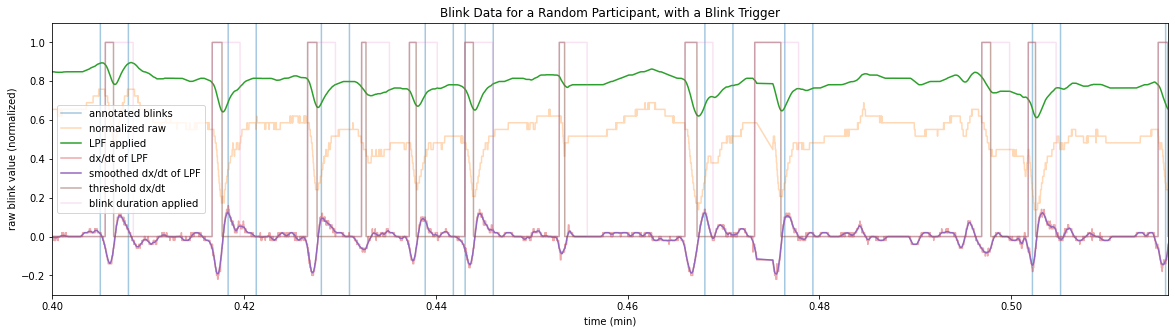

In [81]:
print('select index from 0 to', len(times_to_view))

INDEX = 20
CHOP_START_MIN= 0.4
CHOP_END_MIN = 0.06
SLOW_DOWN_RATIO = 5 #1 for normal speed, 3 for 3x slower
plot_raw(INDEX, chop_start_min=CHOP_START_MIN, chop_end_min=CHOP_END_MIN) 
#stream_with_blink_data_overlay(INDEX, glass_blinks[INDEX], CHOP_START_MIN, CHOP_END_MIN, SLOW_DOWN_RATIO) #could use annot_blinks, video_blinks

0
163.5287


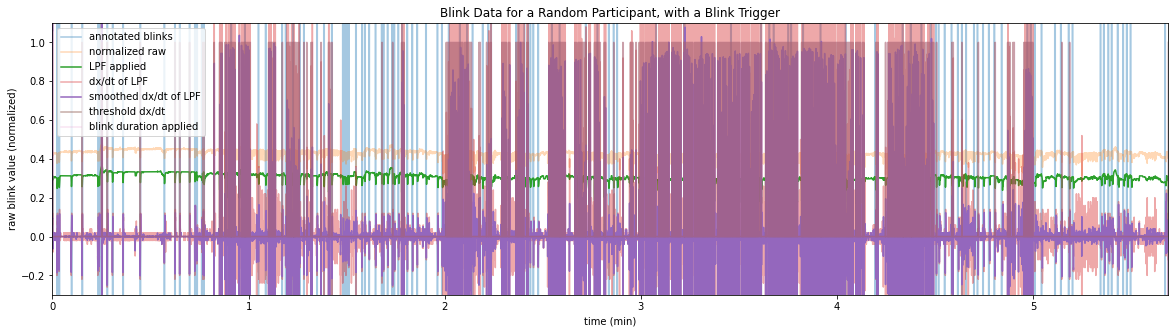

1
20.71998333333333


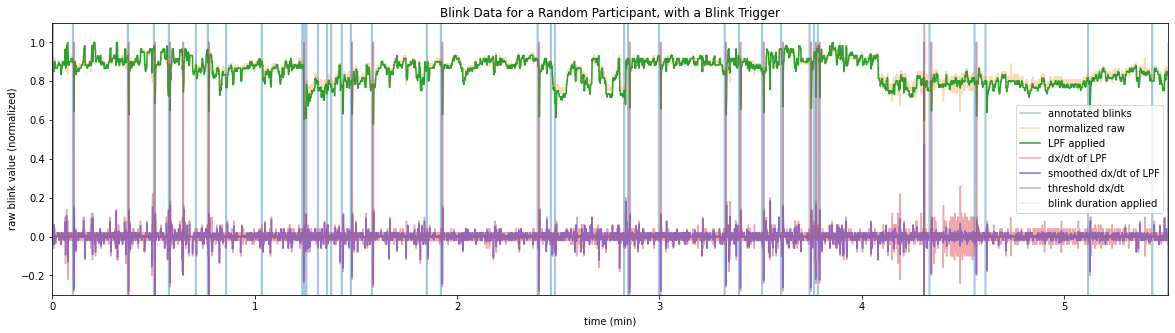

2
465.22425
'NoneType' object is not iterable
3
45.40088333333333


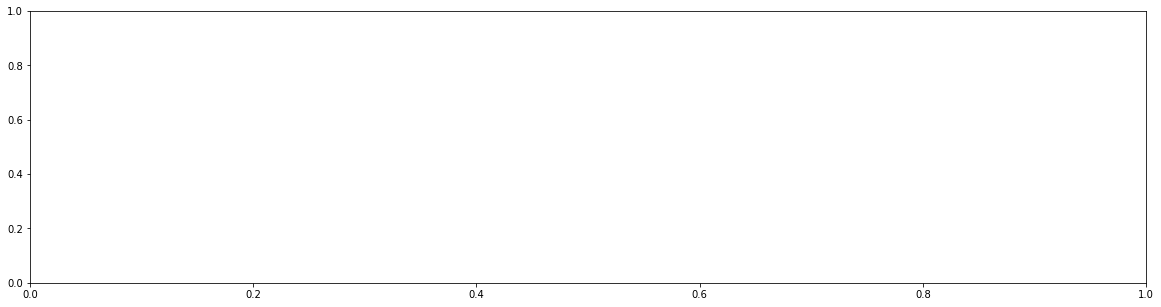

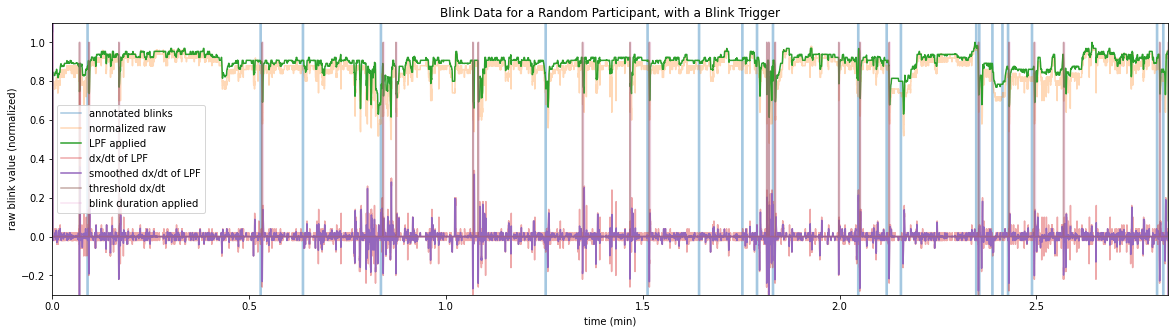

4
105.0102
'NoneType' object is not iterable
5
151.55278333333334


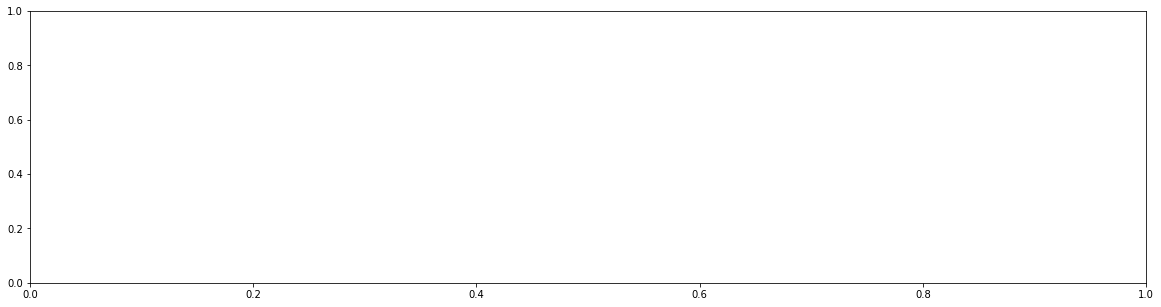

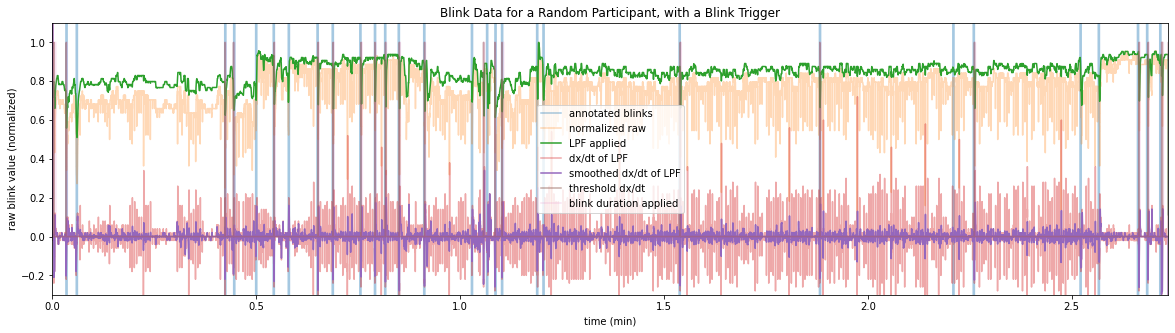

6
108.17171666666667


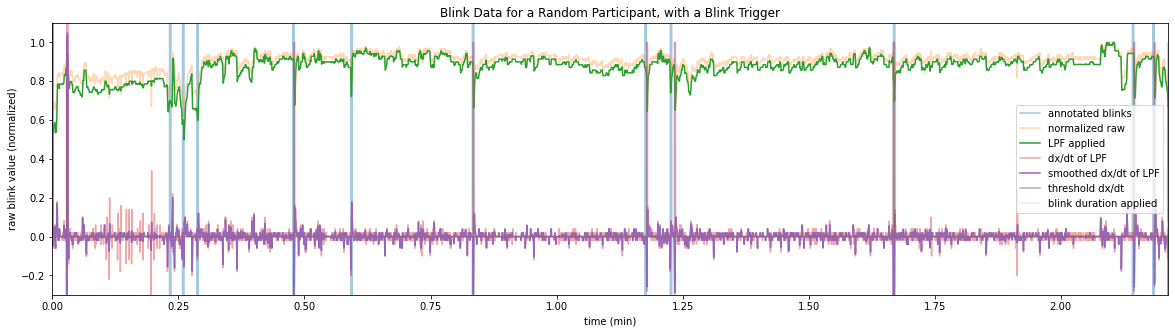

7
154.3125


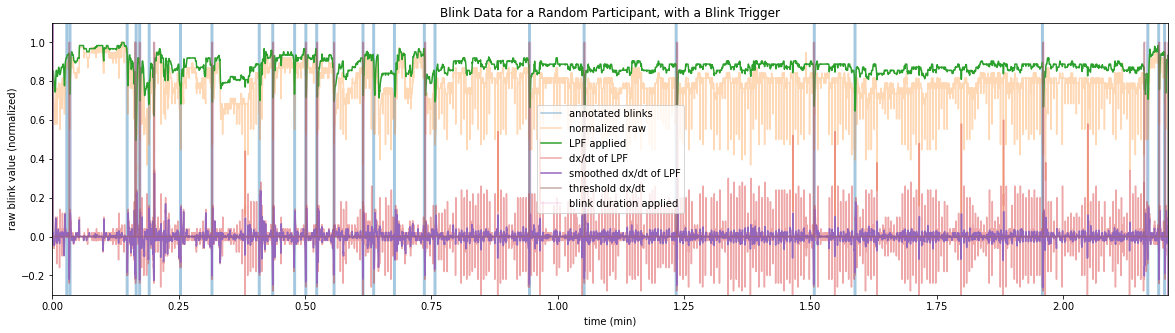

8
1.6789166666666666


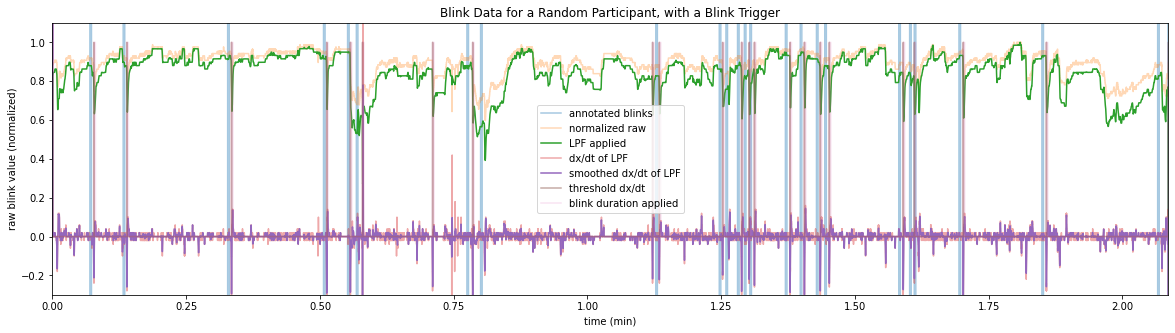

9
230.44175


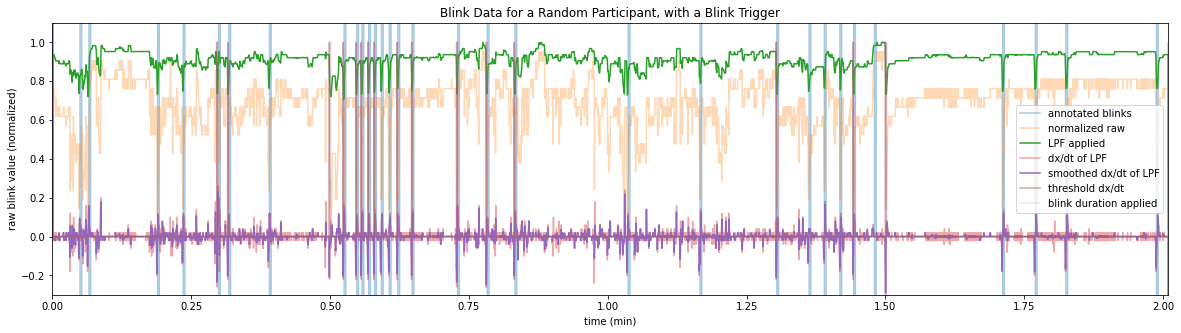

10
224.65426666666667


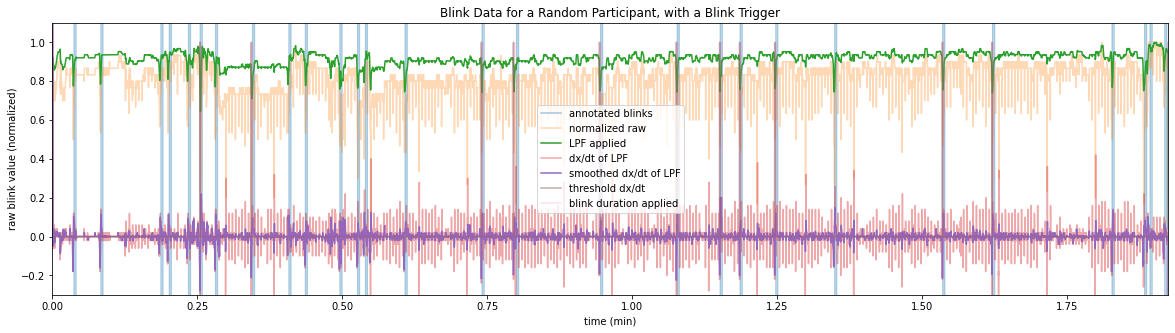

11
48.2404


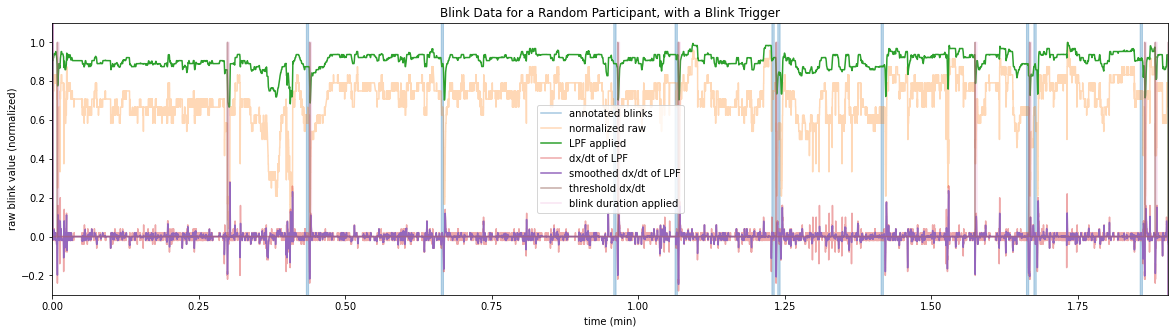

12
240.45958333333334


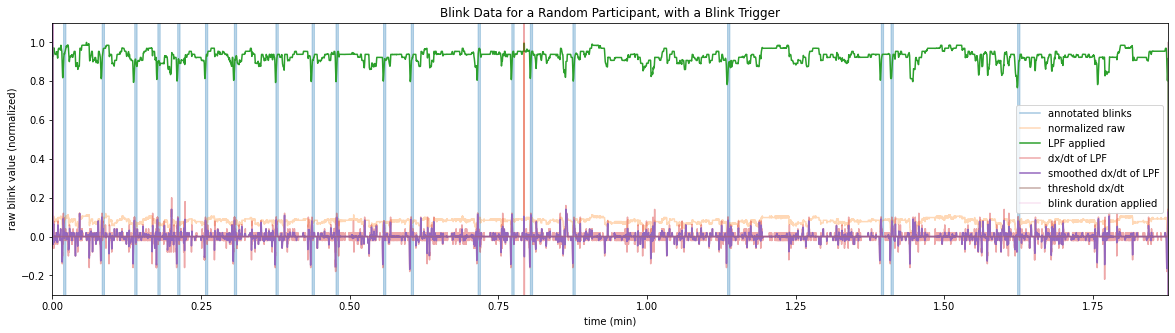

13
13.531933333333333


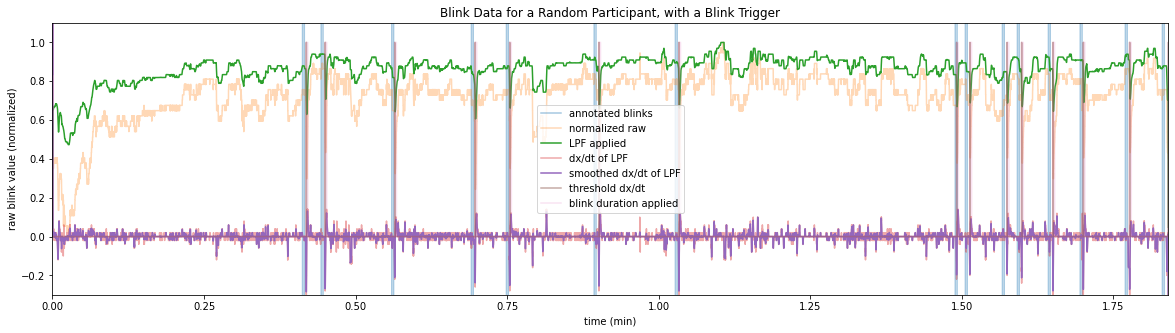

14
469.8397166666667
'NoneType' object is not iterable
15
41.276466666666664


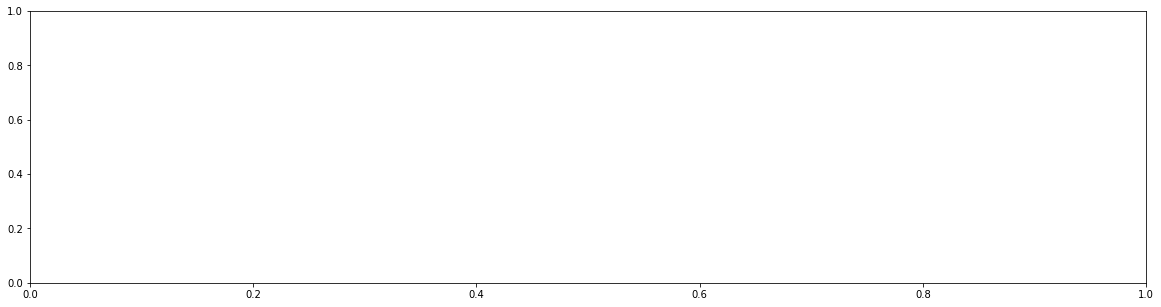

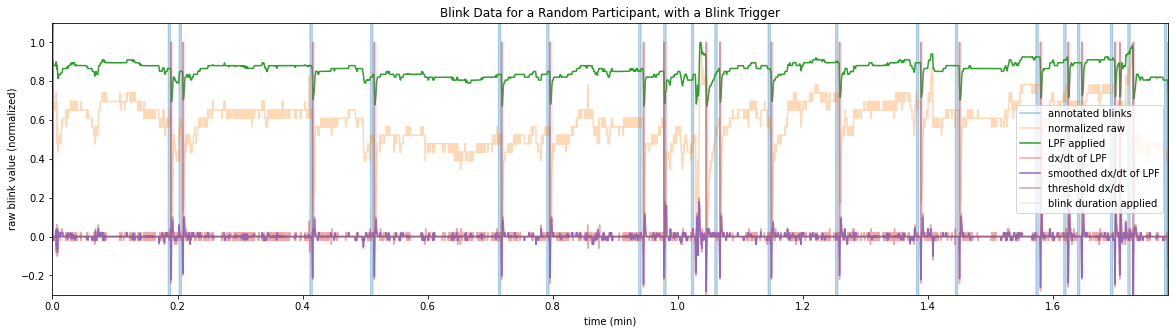

16
15.590666666666667


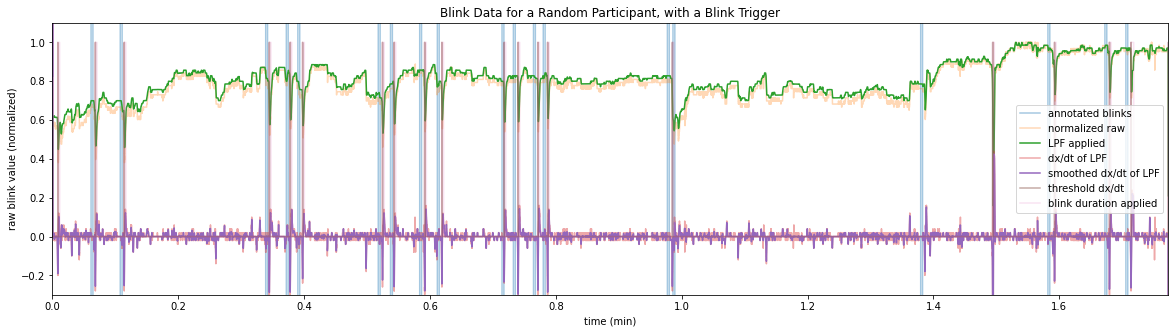

17
144.96533333333332


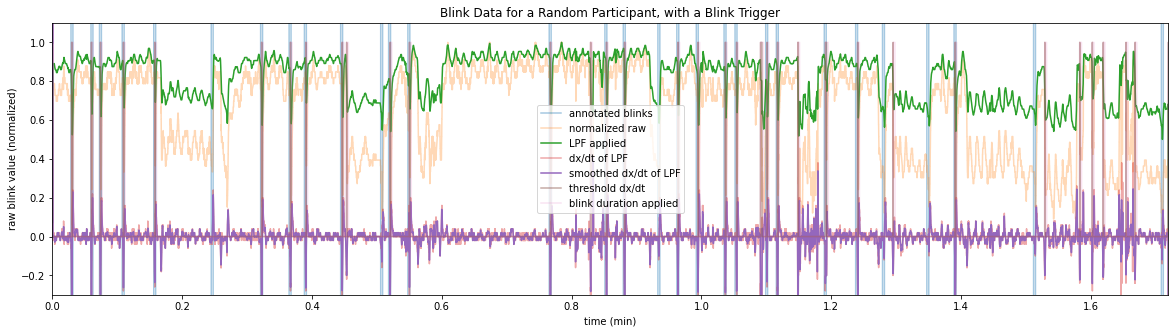

18
238.75231666666667


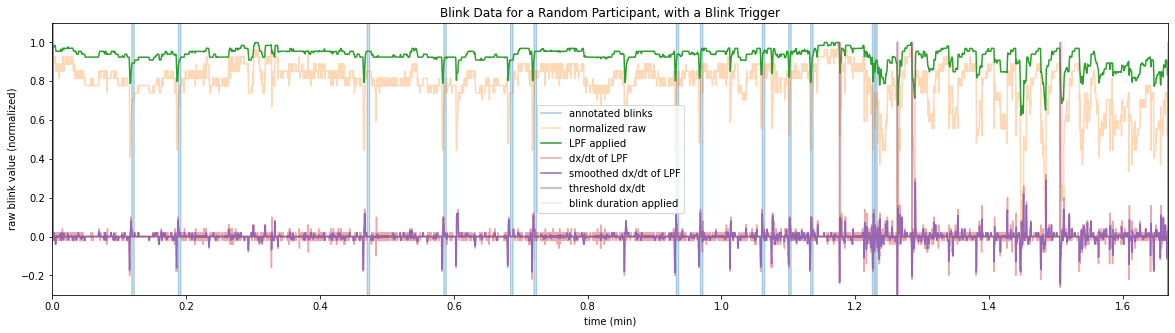

19
473.6616
'NoneType' object is not iterable
20
143.41155


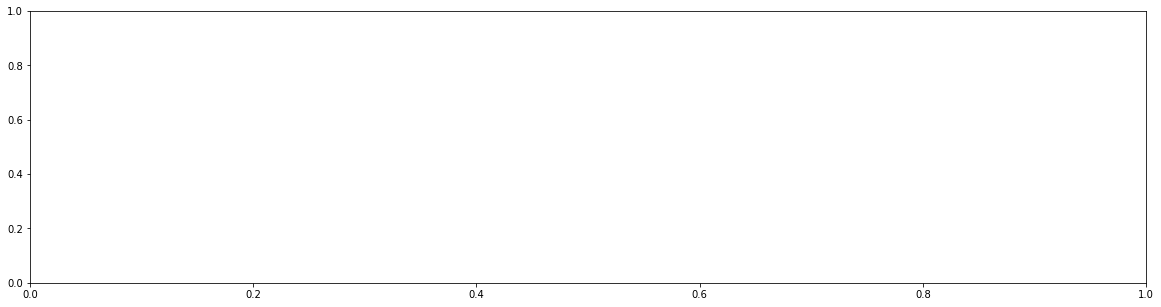

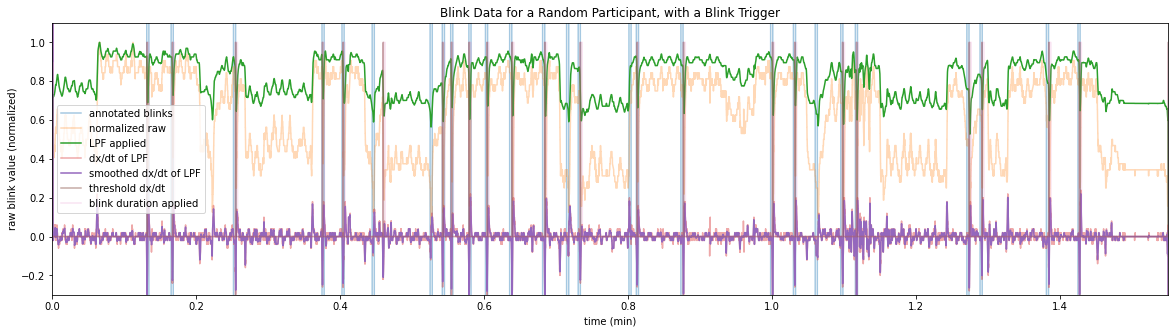

21
468.23338333333334


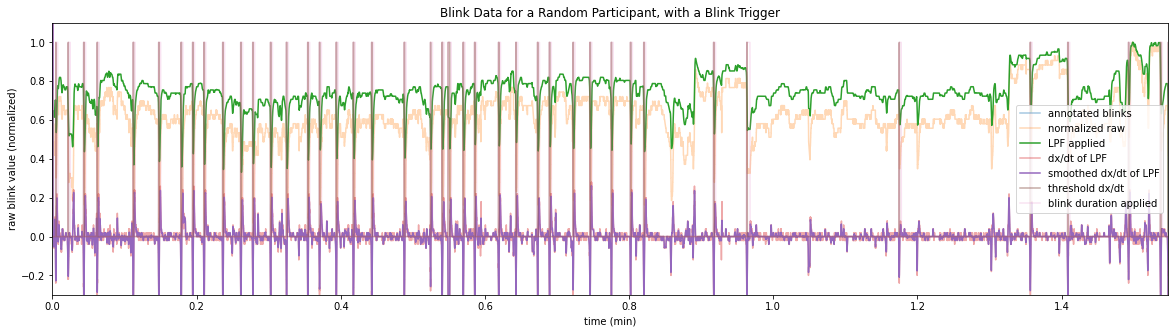

22
221.96378333333334


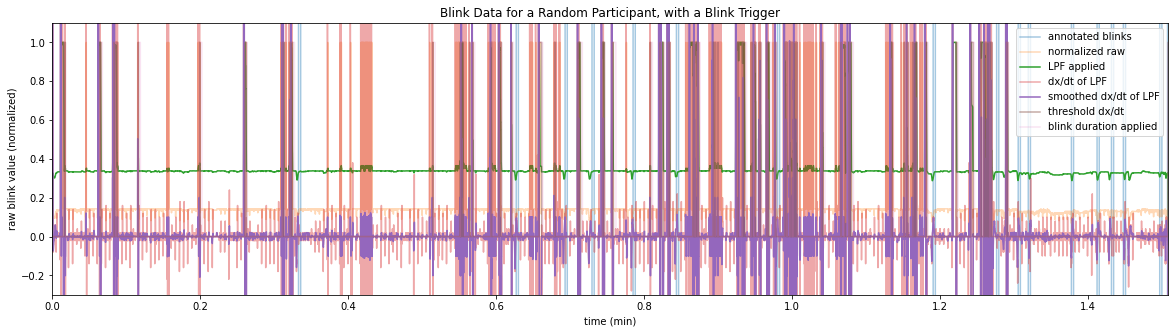

In [68]:
for INDEX in range(len(times_to_view)):
    try:
        print(INDEX)
        print((times_to_view[INDEX][0] - string_to_timestamp_ms(metadata[SESSION]['vid_start']))/60000)
        plot_raw(INDEX, thresh=.19, chop_start_min=CHOP_START_MIN, chop_end_min=CHOP_END_MIN) 
    except Exception as e:
        print(e)
        pass

In [ ]:
GOOD: 157, 128
BAD: 329 (+.1min), 70 (-.01min), 99 (-.02min)
    
ISSUES: 
    
    (1).02/.03 min drift either way
    (2) need a higher threshold
    (3) some firing in the first 2 sec we should ignore

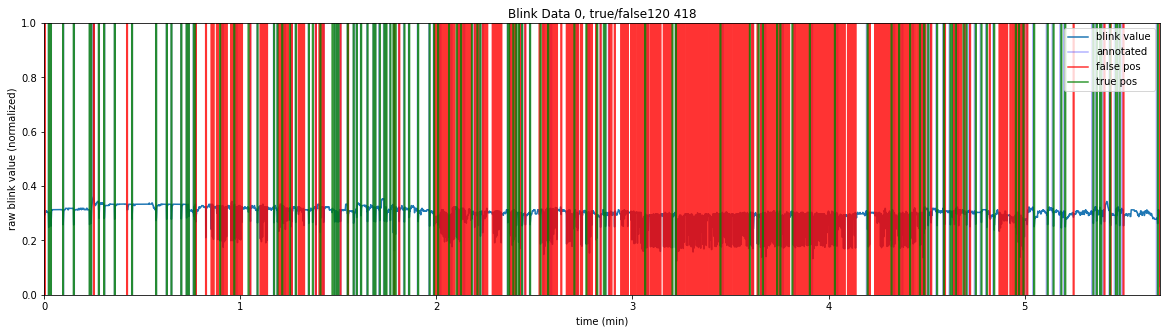

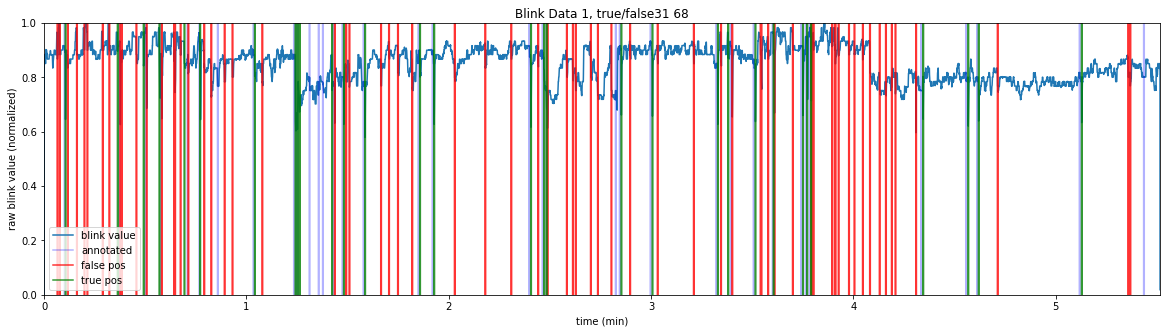

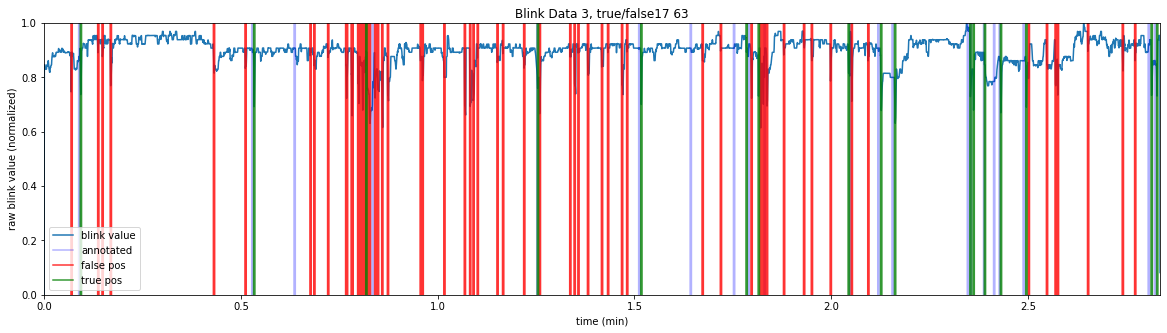

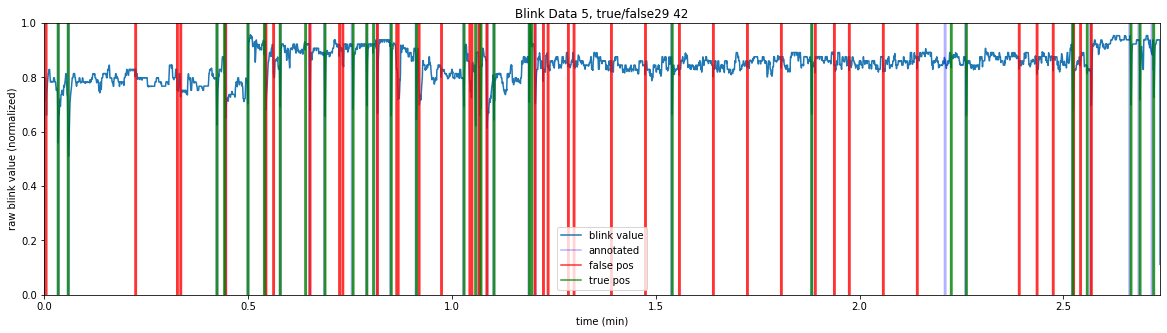

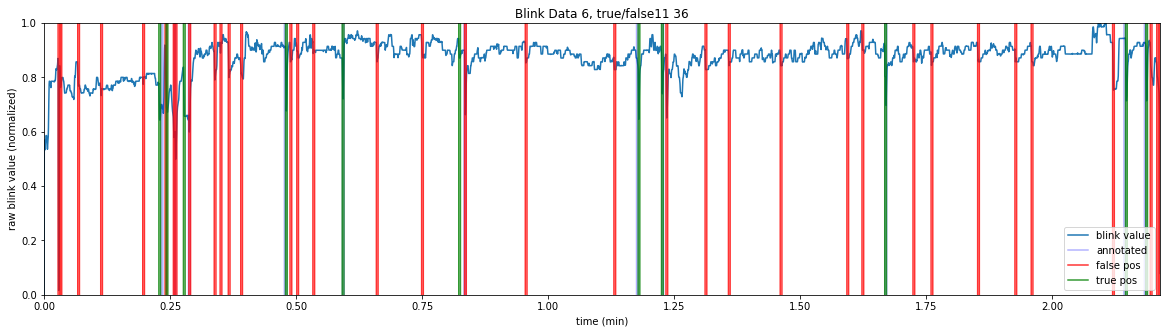

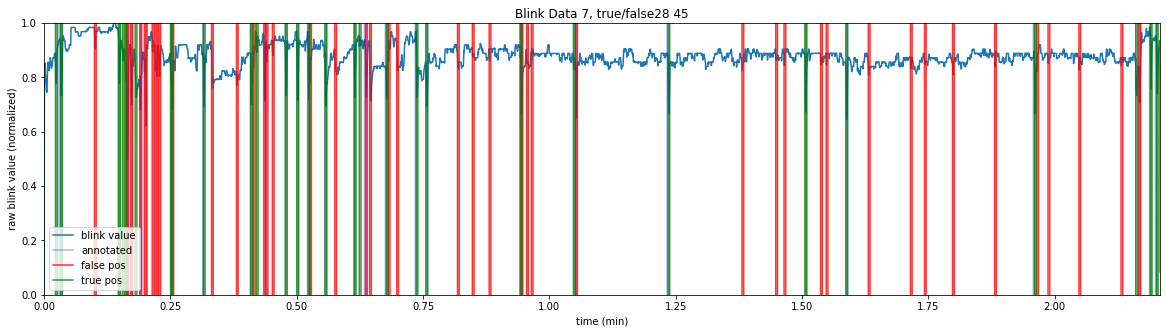

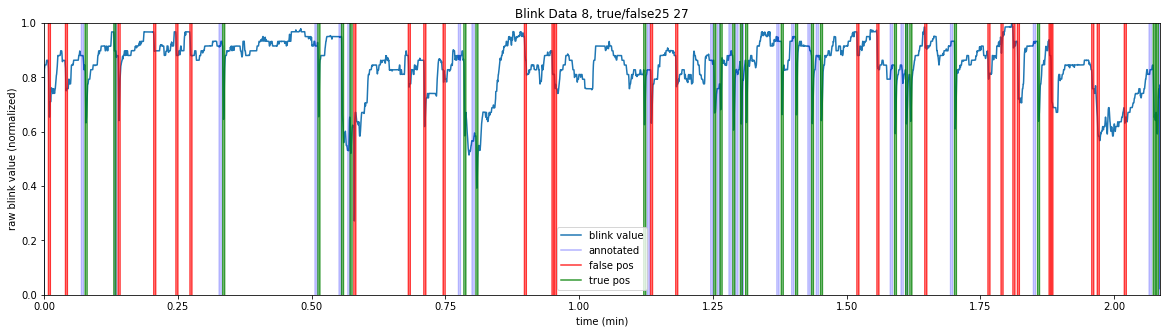

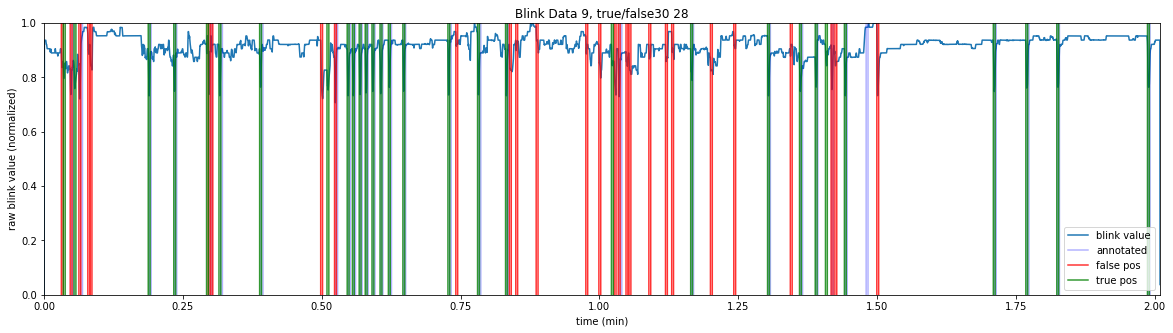

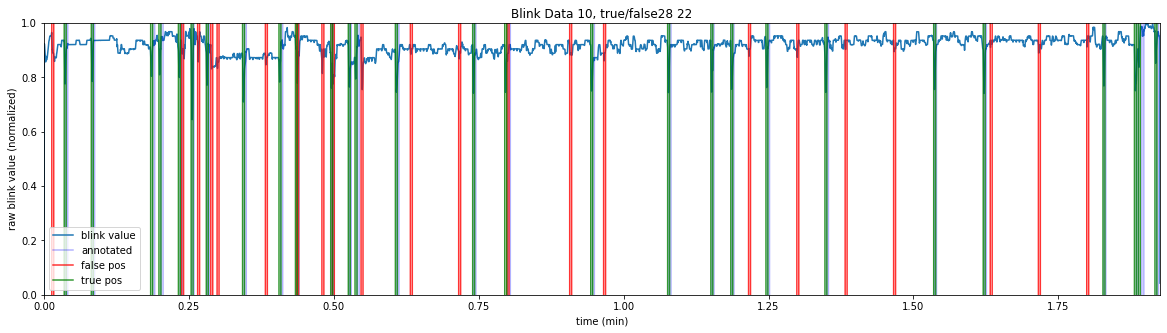

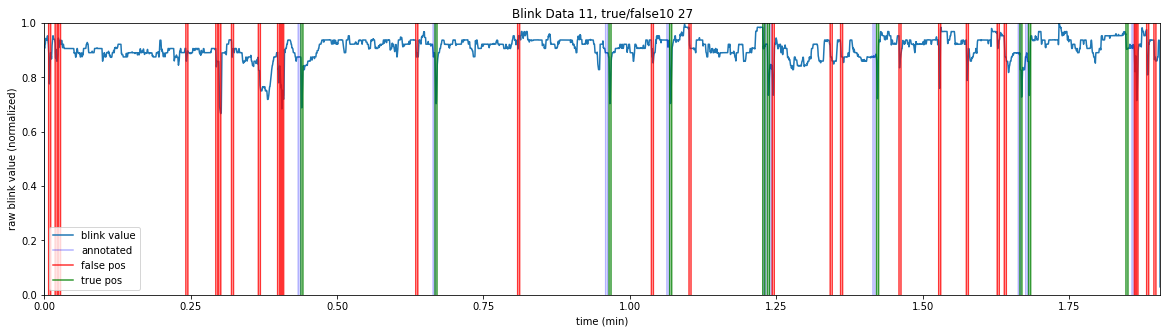

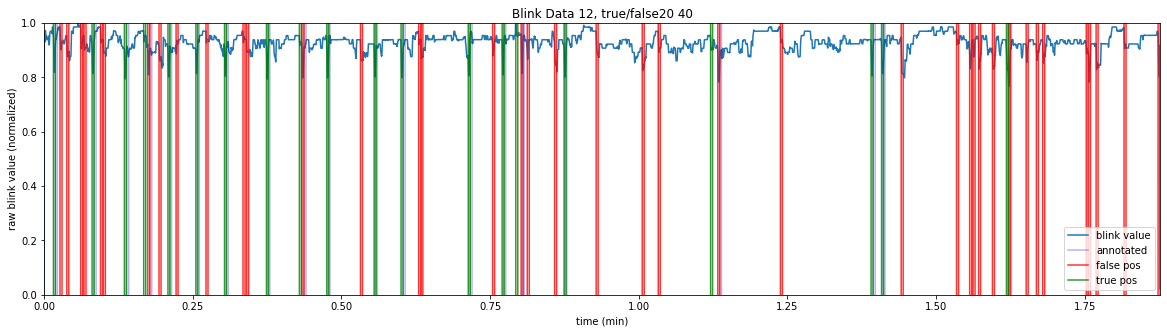

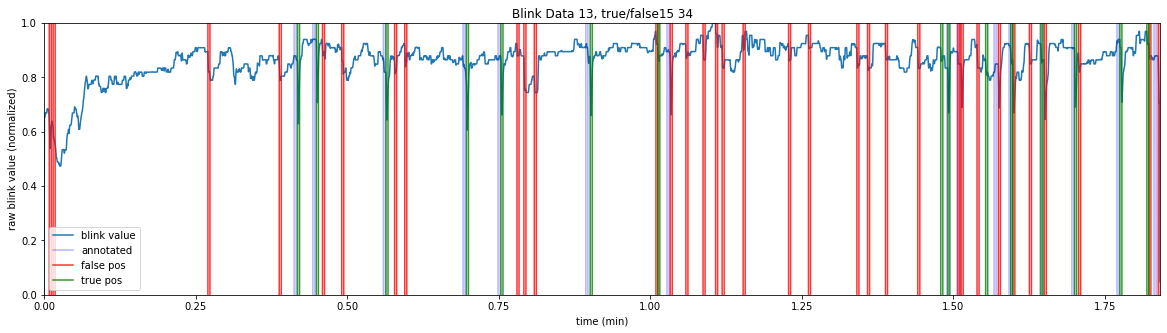

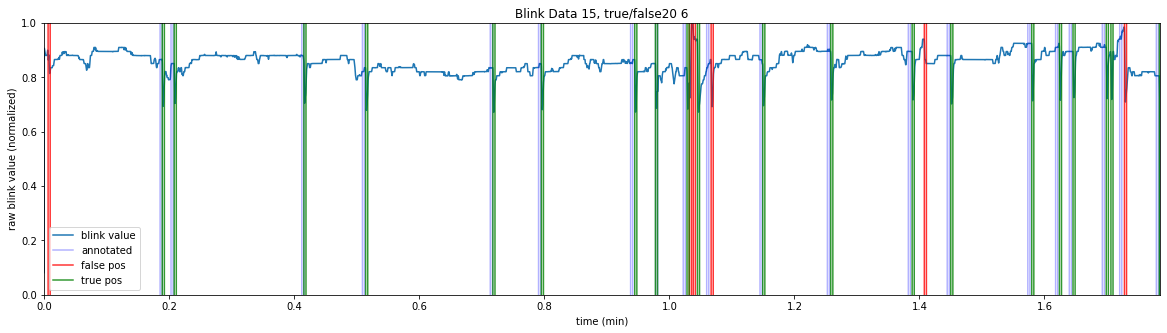

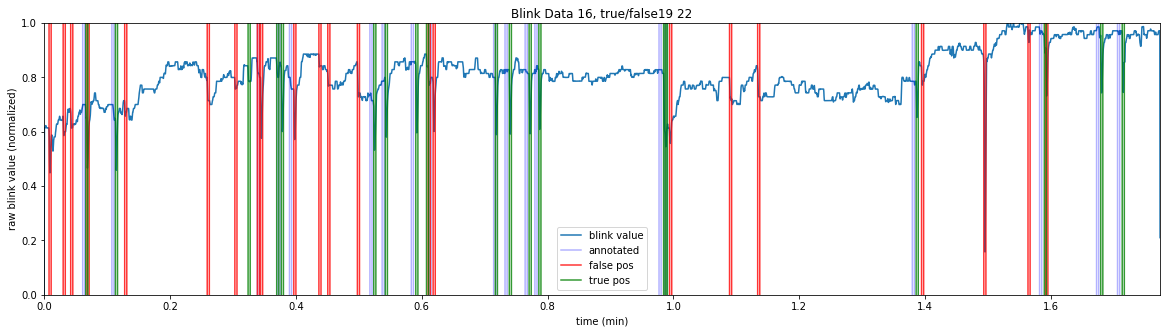

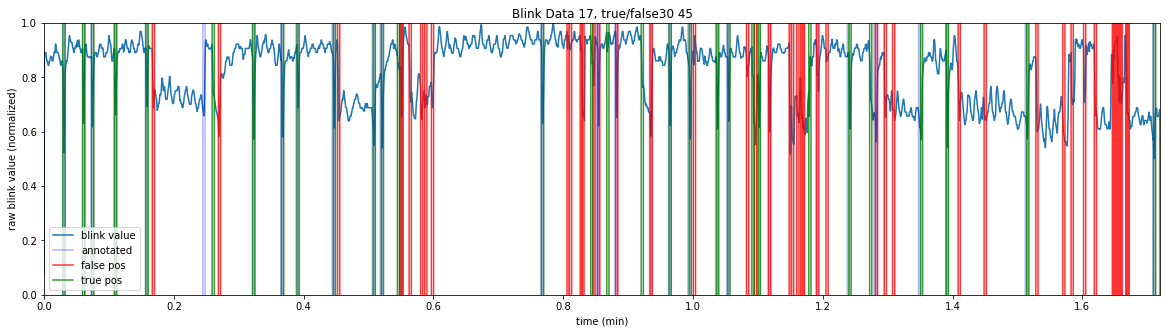

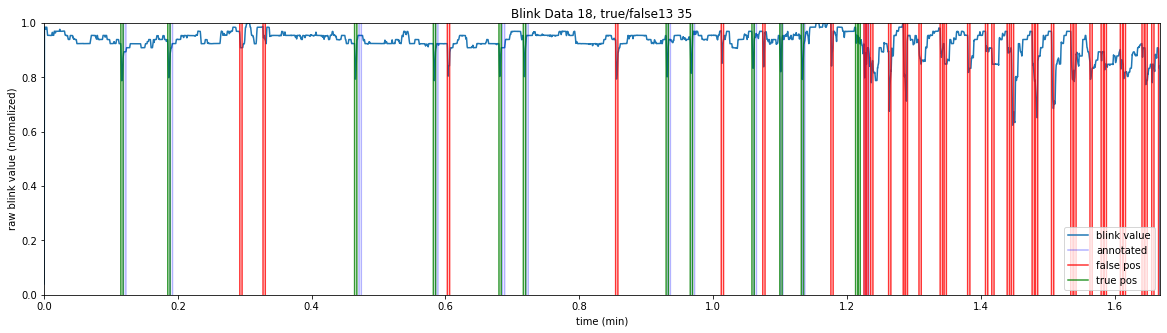

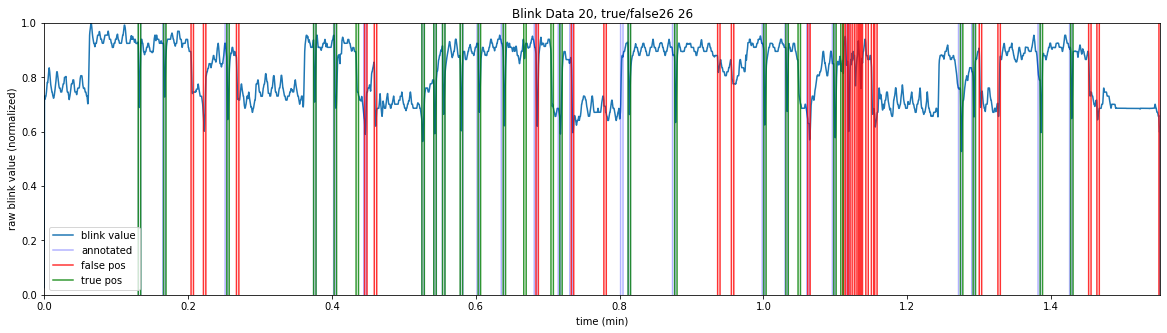

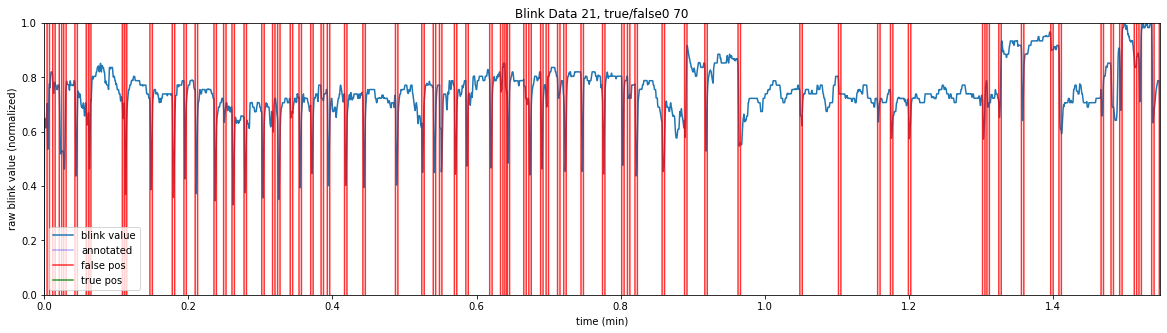

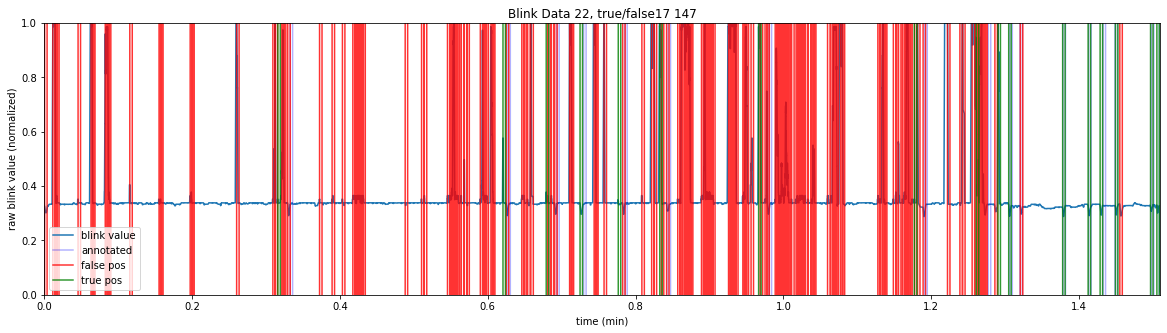

In [13]:
def plot_average_level_and_blink_successfail(lpf_samples=50, blink_dur_ms=200):
    tolerance_ms = 1000
    
    for i in range(len(times_to_view)):
        try:
            annotated_blinklist = annot_blinks[i].copy()
            test_blinklist = glass_blinks[i].copy()
        except Exception as e:
            continue
            
        results = {'true_pos':0, 'real_pos':len(annotated_blinklist)}

        for  atime in annotated_blinklist:
            for ttime in test_blinklist:
                if ttime-tolerance_ms <= atime <= ttime+tolerance_ms:
                    results['true_pos'] += 1
                    test_blinklist.remove(ttime)
                    break


        gblinks_success = [t for t in glass_blinks[i] if t not in test_blinklist]
        gblinks_failed  = [t for t in glass_blinks[i] if t in test_blinklist]

        #now go through times_to_view and plot raw/smoothed
    
        try:
            test_sess = df_between_timestamps(blink_sessions, 'timestamp_ms', times_to_view[i][0], times_to_view[i][1])
        except:
            print('Could not get blink session')
            return

        def moving_average(x, w):
            return np.convolve(x, np.ones(w), 'same') / w

        sess_dur = test_sess['timestamp_ms'].iloc[-1] - test_sess['timestamp_ms'].iloc[0]
        sess_dur /= 1000.

        fig, ax = plt.subplots(figsize=(20,5))

        smoothed = moving_average(test_sess['value'], lpf_samples)
        ax.plot((test_sess['timestamp_ms']-times_to_view[i][0])/60000, (smoothed- min(smoothed))/(max(smoothed)-min(smoothed)), label='blink value')

        times = [[(t-times_to_view[i][0]-1)/60000, (t-times_to_view[i][0])/60000, (t-times_to_view[i][0]+blink_dur_ms)/60000, (t-times_to_view[i][0]+blink_dur_ms+1)/60000] for t in annotated_blinklist]
        values = [-2,2,2,-2]*len(times)
        times = flatten(times)
        ax.plot(times, values, alpha=0.3, label='annotated', color='b')

        times = [[(t-times_to_view[i][0]-1)/60000, (t-times_to_view[i][0])/60000, (t-times_to_view[i][0]+blink_dur_ms)/60000, (t-times_to_view[i][0]+blink_dur_ms+1)/60000] for t in gblinks_failed]
        values = [-2,2,2,-2]*len(times)
        times = flatten(times)
        ax.plot(times, values, alpha=0.8, label='false pos', color='r')

        times = [[(t-times_to_view[i][0]-1)/60000, (t-times_to_view[i][0])/60000, (t-times_to_view[i][0]+blink_dur_ms)/60000, (t-times_to_view[i][0]+blink_dur_ms+1)/60000] for t in gblinks_success]
        values = [-2,2,2,-2]*len(times)
        times = flatten(times)
        ax.plot(times, values, alpha=0.8, label='true pos', color='g')

        
        ax.set_xlabel('time (min)')
        ax.set_ylim(0,1)
        ax.set_xlim(0,  (times_to_view[i][1]-times_to_view[i][0])/60000)
        ax.set_ylabel('raw blink value (normalized)')
        ax.set_title('Blink Data '+str(i)+', true/false' + str(len(gblinks_success)) + ' ' + str(len(gblinks_failed)))
        ax.legend()
        plt.show()

plot_average_level_and_blink_successfail()

In [ ]:
#check that big disruption is where we thought it was

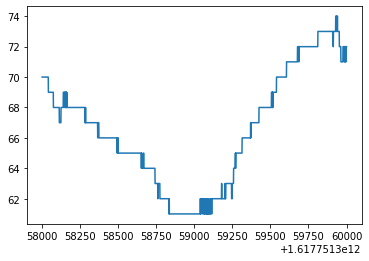

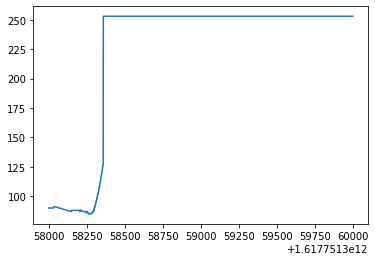

In [22]:
def plot_blink(blink_s, ms_into_vid_start, ms_into_vid_end):
    
    video_start_timestamp_ms = string_to_timestamp_ms(metadata[SESSION]['vid_start'])
    
    start = ms_into_vid_start + video_start_timestamp_ms
    end = ms_into_vid_end + video_start_timestamp_ms
    
    data = df_between_timestamps(blink_s, 'timestamp_ms', start, end)
    
    plt.plot(data['timestamp_ms'], data['value'])
    plt.show()

#1:53:42 should be major disruption
# 1000*s + 1000*60*min + 1000*60*60*hr
time_ms = 1000*42 + 1000*60*53 + 1000*60*60*1
sec_bound = 1000

blink_sessions_uncorrected = pd.concat(blink_sess)
           
plot_blink(blink_sessions_uncorrected, time_ms-sec_bound, time_ms+sec_bound)
           
plot_blink(blink_sessions, time_ms-sec_bound, time_ms+sec_bound)

In [ ]:
def plot_raw(ms_into_vid_start, ms_into_vid_end):
    
    timestamp_start = 
    try:
        test_sess = df_between_timestamps(blink_sessions, 'timestamp_ms', times_to_view[i][0], times_to_view[i][1])
    except:
        print('Could not get blink session')
        return
       
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'same') / w
    
    sess_dur = test_sess['timestamp_ms'].iloc[-1] - test_sess['timestamp_ms'].iloc[0]
    sess_dur /= 1000.
    
    fig, ax = plt.subplots(figsize=(20,5))
        
    times = [[(t-times_to_view[i][0]-1)/60000, (t-times_to_view[i][0])/60000, (t-times_to_view[i][0]+blink_dur_ms)/60000, (t-times_to_view[i][0]+blink_dur_ms+1)/60000] for t in annot_blinks[i]]
    values = [-2,2,2,-2]*len(times)
    times = flatten(times)
    ax.plot(times, values, alpha=0.4, label='annotated blinks')
        
    ax.plot((test_sess['timestamp_ms'] - times_to_view[i][0])/60000, (test_sess['value'] - min(test_sess['value']))/(max(test_sess['value']) - min(test_sess['value'])), alpha=0.3, label='normalized raw')
        
    smoothed = moving_average(test_sess['value'], lpf_samples)
    ax.plot((test_sess['timestamp_ms'] - test_sess['timestamp_ms'].iloc[0])/60000, (smoothed- min(smoothed))/(max(smoothed)-min(smoothed)), label='LPF applied')
    first_der = np.append([0], np.diff(smoothed))
    first_der_smoothed = moving_average(first_der, dx_lpf_samples)
    
    ax.plot((test_sess['timestamp_ms'] - times_to_view[i][0])/60000, first_der, label='dx/dt of LPF', alpha=0.4)
    ax.plot((test_sess['timestamp_ms'] - times_to_view[i][0])/60000, first_der_smoothed, label='smoothed dx/dt of LPF')
    
    decision = (first_der < -1*thresh)
    ax.plot((test_sess['timestamp_ms'] - times_to_view[i][0])/60000, decision, label='threshold dx/dt', alpha=0.5)
    
    blink = []
    samples_per_blink = int((blink_dur_ms / 1000) * 1000) ## 300 ms / 1000ms/s * fps
    ind=0
    while ind<len(decision):
        if decision[ind]:
            blink.extend([1]*samples_per_blink)
            ind += samples_per_blink
        else: 
            blink.append(0)
            ind += 1
    if len(blink)>len(decision): blink = blink[:len(decision)]
    
    ax.plot((test_sess['timestamp_ms'] - times_to_view[i][0])/60000, blink, label='blink duration applied', alpha=0.2)
    
    
    ax.set_xlabel('time (min)')
    ax.set_ylim(-.3,1.1)
    ax.set_xlim(chop_start_min,  (times_to_view[i][1]-times_to_view[i][0])/60000 - chop_end_min)
    ax.set_ylabel('raw blink value (normalized)')
    ax.set_title('Blink Data for a Random Participant, with a Blink Trigger')
    ax.legend()
    
    #plt.savefig('blinkdata_juliana2.png', dpi=500)
    plt.show()

In [ ]:
# plot average level w true pos times and false pos times
# throw away errors in the first and last 500 ms of each thing
# dynamic threshold based on 
#     (1) 10 highest peaks in last min compared 
#     (2) with average ? negative peaks ignoring top 70

